In [24]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Emotions NLP dataset from https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/code

In [1]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  data_path = 'gdrive/MyDrive/cds-project/data/emotions-nlp/' # Replace with path to datasets in your g drive
  glove_path = 'gdrive/MyDrive/cds-project/glove.6B.100d.txt'
else:
  data_path = '../data/emotions-nlp/' # Replace with path to datasets on local machine
  glove_path = '../glove_model/glove.6B.100d.txt'
print("Reading dataset from path " + data_path)

Reading dataset from path ../data/emotions-nlp/


In [2]:
# Import dataset
import pandas as pd
columns = ['text', 'emotion']
df_train = pd.read_csv(data_path + 'train.txt', header=None, sep=';', names=columns, encoding='utf-8')
df_test = pd.read_csv(data_path + 'test.txt', header=None, sep=';', names=columns, encoding='utf-8')
df_val = pd.read_csv(data_path + 'val.txt', header=None, sep=';', names=columns, encoding='utf-8')

In [3]:
# Check data distribution
import seaborn as sns
import matplotlib.pyplot as plt

def plot_emotion_counts(df_train, df_test, df_val, emotion_column):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    sns.countplot(x=df_train[emotion_column].sort_values(), ax=ax[0])
    ax[0].set_title("Training dataset")

    sns.countplot(x=df_test[emotion_column].sort_values(), ax=ax[1])
    ax[1].set_title("Test dataset")

    sns.countplot(x=df_val[emotion_column].sort_values(), ax=ax[2])
    ax[2].set_title("Validation dataset")

    plt.show()

In [8]:
def plot_single_dataset_count(df, df_name, emotion_column):
    title = df_name
    
    sns.countplot(x=df[emotion_column].sort_values())
    plt.suptitle(title)
    plt.show()

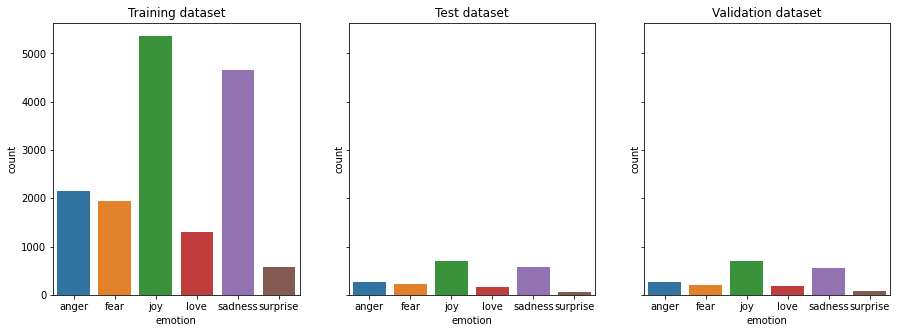

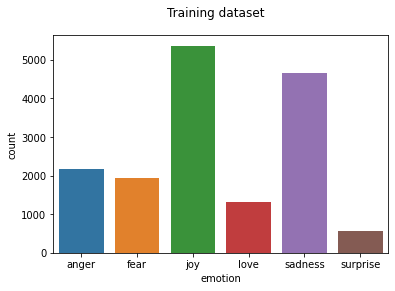

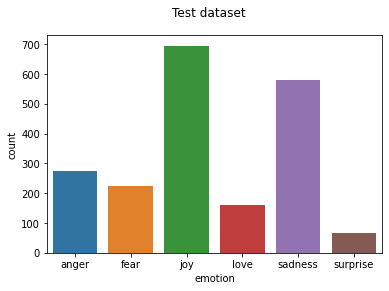

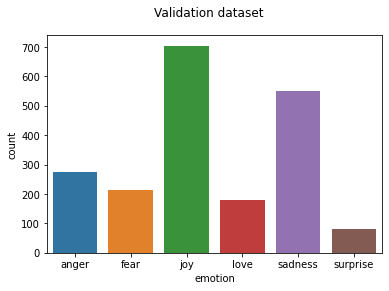

In [9]:
plot_emotion_counts(df_train, df_test, df_val, 'emotion')
plot_single_dataset_count(df_train, "Training dataset", 'emotion')
plot_single_dataset_count(df_test, "Test dataset", 'emotion')
plot_single_dataset_count(df_val, "Validation dataset", 'emotion')



# Data Preprocessing

In [29]:
# Remove stopwords
import nltk, string, re

nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
  text = text.lower() # Convert to lowercase
  text = " ".join([word for word in text.split() if word not in stopwords]) # Remove stopwords
  text = re.sub('\s+', ' ', text) # Remove extra spaces
  text = re.sub("[^-9A-Za-z ]", " ", text) # Remove punctuation
  return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)
df_val['text'] = df_val['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Calculate text lengths
df_train['text_length'] = df_train['text'].apply(lambda txt: len(txt.split()))
df_test['text_length'] = df_test['text'].apply(lambda txt: len(txt.split()))
df_val['text_length'] = df_val['text'].apply(lambda txt: len(txt.split()))
df_train.head()

,text,emotion,text_length
0,didnt feel humiliated,sadness,3
1,go feeling hopeless damned hopeful around some...,sadness,9
2,im grabbing minute post feel greedy wrong,anger,7
3,ever feeling nostalgic fireplace know still pr...,love,7
4,feeling grouchy,anger,2


In [31]:
# Convert emotion to integer
emotions = df_train['emotion'].unique()
emotion_to_id = {}
for id in range(len(emotions)):
  e = emotions[id]
  emotion_to_id[e] = id
output_size = len(emotion_to_id)

In [32]:
df_train['emotion_id'] = df_train['emotion'].apply(lambda e: emotion_to_id[e])
df_test['emotion_id'] = df_test['emotion'].apply(lambda e: emotion_to_id[e])
df_val['emotion_id'] = df_val['emotion'].apply(lambda e: emotion_to_id[e])
df_train.head()

,text,emotion,text_length,emotion_id
0,didnt feel humiliated,sadness,3,0
1,go feeling hopeless damned hopeful around some...,sadness,9,0
2,im grabbing minute post feel greedy wrong,anger,7,1
3,ever feeling nostalgic fireplace know still pr...,love,7,2
4,feeling grouchy,anger,2,1


# Create vocabulary

In [33]:
# Tokenize the text

def tokenize(text):
  return [word for word in text.split()]

In [34]:
# Build vocabulary
from collections import Counter, OrderedDict

all_text = pd.concat([df_train['text'], df_test['text'], df_val['text']])

counts = Counter()
for text in all_text:
  counts.update(tokenize(text))

In [35]:
# Delete infrequently occuring words
print("Number of words before cleaning vocabulary: ", len(counts.keys()))
print("Cleaning vocabulary...")
for word in list(counts):
  if counts[word] < 2:
    del counts[word]
print("Number of words after cleaning vocabulary: ", len(counts.keys()))

Number of words before cleaning vocabulary:  16947
Cleaning vocabulary...
Number of words after cleaning vocabulary:  8279


In [36]:
# Create vocabulary

vocab2index = {"": 0, "UNK":1}
words = list(vocab2index.keys())
for word in counts:
  vocab2index[word] = len(words)
  words.append(word)

In [37]:
# Create Vocab object
from torchtext.vocab import vocab
ordered_dict = OrderedDict(counts.most_common())
vocab = vocab(ordered_dict)

# insert special tokens and set default index to 'unknown'
vocab.insert_token('<PAD>', 0)
vocab.insert_token('<UNK>', 1)
vocab.set_default_index(1)

In [38]:
import numpy as np

def encode_sentence(text, vocab2index, N=70):
  tokenized = tokenize(text)
  encoded = np.zeros(N, dtype=int)
  enc = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
  length = min(N, len(enc))
  encoded[:length] = enc[:length]
  return encoded, length

In [39]:
df_train['encoded'] = df_train['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_test['encoded'] = df_test['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_val['encoded'] = df_val['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_train.head()

,text,emotion,text_length,emotion_id,encoded
0,didnt feel humiliated,sadness,3,0,"[[2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,go feeling hopeless damned hopeful around some...,sadness,9,0,"[[5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0, 0, 0, 0..."
2,im grabbing minute post feel greedy wrong,anger,7,1,"[[14, 15, 16, 17, 3, 18, 19, 0, 0, 0, 0, 0, 0,..."
3,ever feeling nostalgic fireplace know still pr...,love,7,2,"[[20, 6, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,..."
4,feeling grouchy,anger,2,1,"[[6, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# Create GloVe embedding matrix

In [87]:
import torchtext as text

embedding_dim = 100

try:
  vec = text.vocab.GloVe(name='6B', dim=embedding_dim)
  word_emb = vec.get_vecs_by_tokens(vocab.get_itos())
except:
  # Load embedding directly from text file
  print("\nLoading GloVe model from " + glove_path + "...")
  glove_model = {}
  with open(glove_path, 'r') as f:
    for line in f:
      split_line = line.split()
      word = split_line[0]
      embedding = np.array(split_line[1:], dtype=np.float64)
      glove_model[word] = embedding
  print(f"{len(glove_model)} words loaded")

  # Build embedding matrix
  vocab_size = len(vocab.get_itos())
  word_emb = np.zeros((vocab_size, embedding_dim))

  for i, w in enumerate(vocab.get_itos()):
    if i < vocab_size:
      embedding_vector = glove_model.get(w, None)
      if embedding_vector is not None:
        word_emb[i] = embedding_vector

  # Convert to tensor
  word_emb = torch.Tensor(word_emb)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18586.70it/s]


# LSTM with Pretrained GloVe word embeddings

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, word_vec, embed_dim, output_size, hidden_dim = 100, num_layers=2, dropout=0.2):
    super().__init__()
    self.embedding = nn.Embedding(*(word_vec.size())).from_pretrained(word_vec, freeze=False)
    self.embedding.weight.requires_grad = False # Freeze embeddings
    self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(4 * hidden_dim, 64)
    self.dropout = nn.Dropout(dropout)
    self.relu = nn.ReLU()
    self.out = nn.Linear(64, output_size)

  def forward(self, text):
    embedded = self.embedding(text)
    embedded = torch.squeeze(torch.unsqueeze(embedded, 0))

    h_lstm, _ = self.lstm(embedded)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat((avg_pool, max_pool), 1)
    conc = self.relu(self.linear(conc))
    conc = self.dropout(conc)
    out = self.out(conc)
    return out

# Create Dataset and DataLoaders

In [89]:
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [90]:
train_dataset = EmotionDataset(df_train['encoded'], df_train['emotion_id'])
test_dataset = EmotionDataset(df_test['encoded'], df_test['emotion_id'])
val_dataset = EmotionDataset(df_val['encoded'], df_val['emotion_id'])

In [91]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train and evaluate model

In [92]:
from sklearn.metrics import mean_squared_error

def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    train_losses, val_losses, accuracies = [], [], []
    epochs_run = 0
    N = 10
    running_val_loss = 0
    epoch_counter = 0

    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dataloader:
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        epochs_run += 1
        val_loss, val_acc = validation_metrics(model, val_dataloader)
        train_loss = sum_loss/total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(val_acc)

        if i % 5 == 0:
            print("epoch {0} | train loss {1:.3f}, val loss {2:.3f}, val accuracy {3:.3f}".format(i, train_loss, val_loss, val_acc))

        # Early stopping to minimise loss
        if (running_val_loss <= val_loss):
          epoch_counter += 1
          if (epoch_counter == N):
            print(f"Early stopped after {i + 1} epochs")
            break
        else:
          running_val_loss = val_loss
          epoch_counter = 0

    return train_losses, val_losses, accuracies, epochs_run

def validation_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0

    for x, y, l in valid_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        
    return sum_loss/total, correct/total

In [93]:
model = Net(word_vec=word_emb, embed_dim=embedding_dim, output_size=output_size).to(device)

train_losses, val_losses, accuracies, epochs_run = train_model(model, epochs=30)

epoch 0 | train loss 1.596, val loss 1.569, val accuracy 0.366
epoch 5 | train loss 0.409, val loss 0.513, val accuracy 0.820
Early stopped after 10 epochs


In [94]:
# Show training results
def show_results(train_losses, val_losses, accuracies, epochs):
  x = [e for e in range(1, epochs + 1)]

  # show loss results
  plt.plot(x, train_losses, color='b', label='Training loss')
  plt.plot(x, val_losses, color='r', label='Validation loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.title('Loss')
  plt.show()

  # show accuracy results
  plt.plot(x, accuracies)
  plt.xlabel('epochs')
  plt.title('Training accuracy using validation set')
  plt.show()

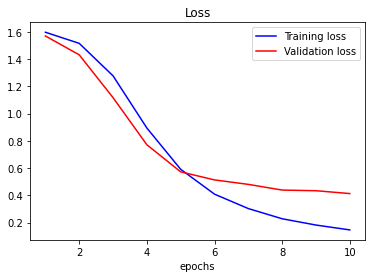

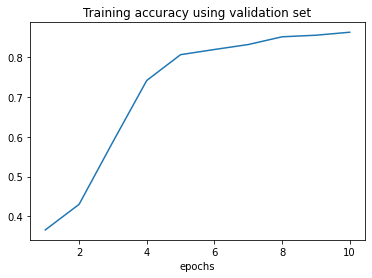

In [95]:
show_results(train_losses, val_losses, accuracies, epochs_run)

In [96]:
# Evaluate model with test set
def evaluate_model(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0

    with torch.no_grad():
      for x, y, l in test_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]

    return sum_loss/total, correct/total

In [97]:
loss, acc = evaluate_model(model, test_dataloader)
print("test loss {0:.3f}, test accuracy {1:.3f}".format(loss, acc))

test loss 0.417, test accuracy 0.861
